In [118]:
## first block of code is just importing everything

import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import cv2
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
from PIL import Image
import imutils
import logging
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from time import perf_counter

In [125]:
# the utility functions
 
def save_obj(obj, name ):
    # save pickle objects
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name ):
    # load pickle objects
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)        


def gray( img ):
    # create grayscale image from database image
    
    # if the image is already grayscale, just return
    if(len(np.shape(img)) < 3):
        return img
#     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    if np.shape(img)[2] == 3:
        img = np.dot( img, [0.299, 0.587, 0.114] )
    else:
        img = np.dot( np.transpose( img, (1,2,0)), [0.299, 0.587, 0.114] )
    return img.astype(np.uint8)

def add_border(img):
    rows,cols = img.shape
    firstcol = img[:,0]
    lastcol = img[:,cols-1]
    firstrow = img[0,:]
    lastrow = img[rows-1,:]
    border = list(np.concatenate((firstcol,lastcol,firstrow,lastrow)))
    common = int(max(set(border), key = border.count))
    array = cv2.copyMakeBorder( img,  10, 10, 10, 10, cv2.BORDER_CONSTANT, value =  common)
    return array.astype(np.uint8)

def prep_img(img):
    img = gray(img)
    img = add_border(img)
    return img

def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [103]:
## all the functions related to zernike and contour
## KARAN PLEASE fix contour, make it so the database entries are (img_index, {crazy contour data})
## ALSO PLEASE seperate the two, create_query(img) should call create_contour, create_zernike, create_sift...
## look at the way I've structured the other methods and try to make these work the same way
## if not, then please talk to me and we can work together on it

# find max distance given a list of points 
def find_max( point_list):

    max_dist = 0.000
    first_point = point_list[0]
    second_point = point_list[1]

    for i in range(0, len(point_list)-1):
        for j in range(i+1, len(point_list)):
            
            dist_sq =  (point_list[i][0] - point_list[j][0])**2 + (point_list[i][1] - point_list[j][1])**2 
            
            if dist_sq > max_dist:
                max_dist = dist_sq
                first_point = point_list[i]
                second_point = point_list[j]
                
    return first_point, second_point, math.sqrt(max_dist)
    
# if object is a circle, find max distance which also has the closest slope to the best fit slope 
def find_tiebreaker( x, y, best_slope, max_dist ):

    first_point = (x[0], y[0])
    second_point = (x[1], y[1])
    min_slope_diff = 999999.999
    
    for i in range(0, len(x)-1):
        for j in range(i+1,len(x)+i):
        
            if j >= len(x):
                j = j % len(x)
            
            dist = math.sqrt( (x[i] - x[j])**2 + (y[i] - y[j])**2 )
            if (max_dist - dist)/max_dist <= 0.08 and (x[i] - x[j]) != 0 :
                slope_diff = abs( (y[i] - y[j])/(x[i] - x[j]) - best_slope )
                
                if slope_diff < min_slope_diff:
                    min_slope_diff = slope_diff
                    first_point = (x[i], y[i])
                    second_point = (x[j], y[j])    

    return first_point, second_point
    

# find midpoints between two points given a set of fractions  
def get_midway (p1, p2, fractions):
    
    midpts = []
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    for n, fract in enumerate(fractions):
        x = p1[0] + fract * dx 
        y = p1[1] + fract * dy 
        midpts.append( (x,y) )
            
    return midpts

# find intersection of 2 lines     
def line_intersect(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) 
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]
    
    div = det(xdiff, ydiff)
    if div == 0:
        return (-999999,-999999) 

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y    
    
# find points of intersection between normal line and all possible line segments in contour 
def find_intersect( x1, y1, x2, y2):
    
    intersect = []
    
    for i in range(0,len(x2)):
        j = i + 1
        if j == len(x2):
            j = 0
        
        # find point of intersection
        point = line_intersect( ((x1[0], y1[0]), (x1[-1], y1[-1])), ((x2[i], y2[i]), (x2[j], y2[j])) )
        
        # check that the point lies on the contour 
        dotproduct = (point[0] - x2[i]) * (x2[j] - x2[i]) + (point[1] - y2[i])*(y2[j] - y2[i])
        squaredlength = (x2[j] - x2[i])**2 + (y2[j] - y2[i])**2
        
        if dotproduct >= 0 and dotproduct <= squaredlength and point not in intersect:
            intersect.append( point )

    return intersect

def canny(img):
	cimg = cv2.Canny(img,100,200)
	if np.amax(cimg,axis=(0,1)) == 0:
		cimg = cv2.Canny(img,20,100)
	if np.amax(cimg,axis=(0,1)) == 0:
		cimg = cv2.Canny(img,5,20)
	if np.amax(cimg,axis=(0,1)) == 0:
		cimg = cv2.Canny(img,1,5)	
	return cimg

def fill_in_diagonals(img):
	rows,cols = img.shape[:2]
	min_x = cols 
	min_y = rows
	max_x = 0 
	max_y = 0 
	# fill in any diagonals in the edges 
	for i in range(0, rows):
		for j in range(0, cols):
			if  i >= 1 and i <= rows - 2 and j >= 1 and j <= cols - 2: 
				if img[i,j] == 255 and img[i,j-1] == 0 and img[i+1,j] == 0 and img[i+1,j-1] == 255:
					img[i+1,j] = 255 
				elif img[i,j] == 255 and img[i,j+1] == 0 and img[i+1,j] == 0 and img[i+1,j+1] == 255:
					img[i+1,j] = 255 
			
			if img[i,j] == 255:
				if j > max_x:
					max_x = j 
				if j < min_x:
					min_x = j
				if i > max_y:
					max_y = i 
				if i < min_y: 
					min_y = i
	return img, rows, cols, min_x, min_y, max_x, max_y

def image_preprocess(img):
	img = gray(img)
	rows,cols = img.shape[:2]
	# create grayscale image and use Canny edge detection
	cimg = canny(img)	
	
	dcimg, rows, cols, min_x, min_y, max_x, max_y = fill_in_diagonals(cimg)
	
	return rows, cols, min_x, min_y, max_x, max_y, dcimg

def edge_detect( img ):

    edges1 = canny(img)

    edges2, rows, cols, min_x, min_y, max_x, max_y = fill_in_diagonals(edges1)
                    
    edges2 = edges2[min_y:max_y+1, min_x:max_x+1]
    row_dist = max_y+1-min_y
    col_dist = max_x+1-min_x
    scale = int(1000 / max(row_dist,col_dist))
    try:
        edges2 = cv2.resize(edges2, dsize=(row_dist*scale, col_dist*scale), interpolation=cv2.INTER_CUBIC)                
    except:
        edges2 = edges1
        
    return edges1, edges2 

def find_contours(img):
    img_gamma = adjust_gamma(img, .33)
    rows,cols = img.shape[:2]

    # create grayscale image and use Canny edge detection
    edges1, edges2 = edge_detect(img)
    edges_gamma, edges2_gamma = edge_detect(img_gamma) 
    
    # find contours from edge image
    try:
        image, contours, hierarchy = cv2.findContours(edges1,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    except:
        contours, hierarchy = cv2.findContours(edges1,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    
    try:
        contours_gamma, hier = cv2.findContours(edges_gamma,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    except:
        image, contours_gamma, hier = cv2.findContours(edges_gamma,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
            
    total_perimeter = 0
    for n, contour in enumerate(contours):
        total_perimeter += cv2.arcLength(contour,False)
        
    total_perimeter_gamma = 0
    for n, contour_g in enumerate(contours_gamma):
        total_perimeter_gamma += cv2.arcLength(contour_g,False)  
        
    if total_perimeter_gamma >= 1.1 * total_perimeter:
        contours = contours_gamma
        edges2 = edges2_gamma
        
    return contours, edges2

def create_zernike(img):
    
    contours, edges = find_contours(img)

    try:
        zernike = mahotas.features.zernike_moments(edges, 16)    
        zernike = normalize(zernike[:,np.newaxis], axis=0).ravel()    
    except:
        zernike = [0] * 25
            
    return zernike

def compare_zernike( z1, z2):
    
    dot_prod = sum(i[0] * i[1] for i in zip( z1, z2 ))
    score = round(666.667 * max((dot_prod - .850),0),1)
    
    return score    

def test_zernike( z, hash_zernike, candidates = None ):

    zernike_list = []
  
	if candidates is None:
		candidates = hash_zernike.keys()
    
    for image_index in tqdm_notebook( candidates ):
    
        score = compare_zernike( z, hash_zernike.get(image_index))
        zernike_list.append(( image_index, score ))
        
    return zernike_list 

def generate_database_zernike( images ):
	database  = {}
	for img_index in range(len(images)):
		if img_index%50 == 0:
			print(img_index)
		img = images[img_index]
		database[img_index] = create_zernike(img)
	return database

def create_query( img, fractions ):
    ## PLEASE separate zernike and contour
    ## especially with the gamma stuff going on I can't safely pull them apart myself, you understand what's
    ## going on so please do so.
    rows,cols = img.shape[:2]
    contours, edges = find_contours(img)
    dist_append = []
    
    # find hull and defects of the contour 
    for n in range(0,len(contours)):
    
        cnt = contours[n]
        hull = cv2.convexHull(cnt,returnPoints = False)
        defects = cv2.convexityDefects(cnt,hull)
        
        # initialize list to track all points on the hull as well as points with defects 
        point_track = []
        
        for j in range (hull.shape[0]):    
            i = hull[j]
            point = tuple(cnt[i][0][0])
            point_track.append(point)
        
        if defects is not None:
            for i in range(defects.shape[0]):
                s,e,f,d = defects[i,0]
                far = tuple(cnt[f][0])
                point_track.append(far)
        
        # 4b. find max distance and plot 2 points along with longest line 
        if len(point_track) >= 2:
            [point1, point2, max_dist, point3, point4, second_dist] = find_max(point_track)
            ratio_dist = second_dist/max_dist
        
            # find midway points along line segment  
            midpts = get_midway( point1, point2, fractions ) 
            
            # slope of normal line 
            if (point2[0]-point1[0]) == 0:
                slope = 0
            elif (point2[1]-point1[1]) == 0:
                slope = 10000
            else:
                slope = -1 / ( (point2[1]-point1[1]) / (point2[0]-point1[0]) )
        
            # 4d. loop through the middle/quarter/eighth points and plot the normal lines 
            for m, pt in enumerate(midpts):
    
                x = np.linspace(0.0,cols,3)
                y = [float(slope * i - slope * pt[0] + pt[1]) for i in x]  
                
                if n == 0:
                    for n1 in range(0,len(contours)):
                        cnt1 = contours[n1]    
                    
                        # find points of intersection between normal line and contour, plot those points
                        intersect = find_intersect(x, y, cnt1[:,0,0], cnt1[:,0,1])
                        
                        # distance between middle point and intersect points, normalize using length of longest line
                        dist = [ round( math.sqrt( (i[0] - pt[0])**2 + (i[1] - pt[1])**2 ) / max_dist , 3 ) for i in intersect ]
                        for d in dist:
                            if (fractions[m],d) not in dist_append:
                                dist_append.append((fractions[m],d))
                                
                else:
                    # find points of intersection between normal line and contour, plot those points
                    intersect = find_intersect(x, y, cnt[:,0,0], cnt[:,0,1])
                    
                    # distance between middle point and intersect points, normalize using length of longest line
                    dist = [ round( math.sqrt( (i[0] - pt[0])**2 + (i[1] - pt[1])**2 ) / max_dist , 3 ) for i in intersect ]
                    for d in dist:
                        if (fractions[m],d) not in dist_append:
                            dist_append.append((fractions[m],d))
                            
            # find midway points along second best line segment  
            if n <= 1 and ratio_dist >= .988:
                midpts2 = get_midway( point3, point4, fractions ) 
                
                # slope of normal line 
                if (point4[0]-point3[0]) == 0:
                    slope2 = -1 / ( (point4[1]-point3[1]) / (point4[0]-point3[0] + 0.0001) )
                elif (point4[1]-point3[1]) == 0:
                    slope2 = -1 / ( (point4[1]-point3[1] + 0.0001) / (point4[0]-point3[0]) )
                else:
                    slope2 = -1 / ( (point4[1]-point3[1]) / (point4[0]-point3[0]) ) 
                
                for m, pt in enumerate(midpts2):
                    x1 = np.linspace(0,cols,num=cols+1)
                    y1 = [slope2 * i - slope2 * pt[0] + pt[1] for i in x1] 
    
                    intersect = find_intersect(x1, y1, cnt[:,0,0], cnt[:,0,1])
                    if len(intersect) > 0:
                    
                        # distance between middle point and intersect points, normalize using length of longest line
                        dist = [ round( math.sqrt( (i[0] - pt[0])**2 + (i[1] - pt[1])**2 ) / second_dist , 2 ) for i in intersect ]
                        for d in dist:
                            if (fractions[m],d) not in dist_append:
                                dist_append.append((fractions[m],d))              

    
    ## create final dictionary for contour method distances    
    query = {}        
    for d in dist_append:
        query.setdefault(d[0],[]).append(d[1])    
        
    return query         

def compare_contour( query1, query2, error, fractions):
    
    total_points = 0
    matched = 0
    reverse_matched = 0
    
    # loop through each of the fractions (key of the dictionary)
    for f in fractions:
        
        for dist in query2.get(f):
    
            total_points += 1
            
            for query_dist in query1.get(f):
                
                if query_dist >= dist - error and query_dist <= dist + error:
                    
                    matched += 1
                    break
                    
            for query_dist in query1.get(round(1-f,1)):
                
                if query_dist >= dist - error and query_dist <= dist + error:
                    
                    reverse_matched += 1
                    break
                    
    matched = max(matched, reverse_matched)
    if total_points > 0:
        score = round( float( 100 * matched/total_points ), 1 )
    else:
        score = 0
        
    return score    
    
def test_contour( image_query, hash_contour, error, fractions, candidates = None ):
    
    # track all of the matched images
    contour_list = []
    
	if candidates is None:
		candidates = hash_contour.keys()

    # loop through each of the fractions (key of the dictionary)
    for image_index in tqdm_notebook( candidates ):
        score = compare_contour( image_query, hash_contour.get(image_index), error, fractions )
        contour_list.append(( image_index, score ))
        
    return contour_list 

def generate_database_contour( images, fractions):
	database  = {}
	for img_index in range(len(images)):
		if img_index%50 == 0:
			print(img_index)
		img = images[img_index]
		database[img_index] = create_query(img, fractions)
	return database

In [130]:
# sift

class sift_method(object):
    # all the methods are structured the same, so I'm mostly commenting this one as an example
    # hold the database internally to avoid passing it around so much
	database = {}
    # and define all the auxilliary stuff needed for the method to run
    # parameters, objects, etc...
	sift = cv2.xfeatures2d.SIFT_create()
	FLANN_INDEX_KDTREE = 0
	index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
	search_params = dict(checks=50)   # or pass empty dictionary
	matcher = cv2.FlannBasedMatcher(index_params,search_params)

	def __init__(self, database = None):
        # if the database is passed in, make it the internally stored database
        # otherwise it stays empty
		if database:
			self.database = database

	def create_query(self, img):
        # run the method on a single image
        
        # preproccess the image
		img = gray(img)
		img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)
		
		# find the keypoints and descriptors with sift
		kp1, des1 = self.sift.detectAndCompute(img,None)
        # if sift doesn't give us enough info to match, return none
		if len(kp1) < 2:
			des1 = None
		return des1

	def compare_queries(self, img_kp1, img_kp2):
        # compare the queries generated by two images to obtain a similarity score
        
        # if either of the two image queries is missing, then return 0
		if img_kp1 is None:
			return 0
		if img_kp2 is None:
			return 0
        # try to run the matcher, if it fails return 0
		try:
			matches = self.matcher.knnMatch(img_kp1, img_kp2, k=2)
		except:
			return 0
			
        # count up the number of matches that are "close enough"
		score = 0
		for i,(m,n) in enumerate(matches):
			if m.distance < 0.7*n.distance:
				score += 1
		return score

	def test_query(self, img_kp, candidates=None):
        # test the given image query against the internal database
        # if a list of candidates to try is passed in, only check against those
        
		sift_list = []
		if candidates is None:
			candidates = self.database.keys()
		for img_index in candidates:
			sift_list.append((img_index, self.compare_queries(img_kp, self.database[img_index])))
		best = 1
		for i in sift_list:
			if i[1] > best:
				best = i[1]
		sift_list = [(x[0],round(100 * x[1]/best)) for x in sift_list]
		return sift_list

	def generate_database(self, images):
        # generate an image database from the given images, store as the internal database and also return it
		self.database  = {}
		for img_index in range(len(images)):
			if img_index%50 == 0:
				print(img_index)
			img = images[img_index]
			self.database[img_index] = self.create_query(img)
		return self.database

In [134]:
# orb

class orb_method(object):
	database = {}
	orb = cv2.ORB_create()

	def __init__(self, database = None):
		if database:
			self.database = database

	def create_query(self, img):
		img = gray(img)
		img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

		# find the keypoints and descriptors with orb
		kp1, des1 = self.orb.detectAndCompute(img,None)
		if len(kp1) < 2:
			des1 = None
		return des1

	def compare_queries(self, img_kp1, img_kp2):
		if img_kp1 is None:
			return 0
		if img_kp2 is None:
			return 0
		matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
		matches = matcher.match(img_kp1,img_kp2)
		score=len(matches)
		return score

	def test_query(self, img_kp, candidates=None):
		orb_list = []
		if candidates is None:
			candidates = self.database.keys()
		for img_index in candidates:
			orb_list.append((img_index, self.compare_queries(img_kp, self.database[img_index])))
		best = 1
		for i in orb_list:
			if i[1] > best:
				best = i[1]
		orb_list = [(x[0],round(100 * x[1]/best)) for x in orb_list]
		return orb_list

	def generate_database(self, images):
		self.database  = {}
		for img_index in range(len(images)):
			if img_index%50 == 0:
				print(img_index)
			img = images[img_index]
			self.database[img_index] = self.create_query(img)
		return self.database

In [106]:
# neural

class neural_method(object):
	database = {}
	# Load the pretrained model
	model = models.resnet18(pretrained=True)
	#strip the final layer to get a feature vector
	model = nn.Sequential(*list(model.children())[:-1])  
	# Set model to evaluation mode
	model.eval()

	def __init__(self, database = None):
		if database:
			self.database = database

	def create_query(self, img):
		scaler = transforms.Resize((224, 224))
		normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
			std=[0.229, 0.224, 0.225])
		to_tensor = transforms.ToTensor()
		pillize = transforms.ToPILImage()
		loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
		l_img = loader(img)
		t_img = Variable(l_img).unsqueeze(0)
		f_vec = self.model(t_img).squeeze()
		return f_vec.detach().numpy()

	def compare_queries(self, v1, v2):
		sim = np.dot(v1, v2)
		return sim.item()

	def test_query(self, img_vec, candidates=None):
		neural_list = []
		if candidates is None:
			candidates = self.database.keys()
		for img_index in candidates:
			neural_list.append((img_index, self.compare_queries(img_vec, self.database[img_index])))
		return neural_list

	def generate_database(self, images):
		self.database  = {}
		for img_index in range(len(images)):
			if img_index%50 == 0:
				print(img_index)
			img = images[img_index]
			self.database[img_index] = self.create_query(img)
		return self.database

In [107]:
# zernike, minus the gamma correction stuff

class zernike_method(object):
	database = {}

	def __init__(self, database = None):
		if database:
			self.database = database

	def create_query(self, img):
		_, _, min_x, min_y, max_x, max_y, edges1 = image_preprocess(img) 
		## create zernike vector 
		edges2 = edges1[min_y:max_y+1, min_x:max_x+1]
		edges2 = cv2.resize(edges2, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
		zernike = mahotas.features.zernike_moments(edges2, 16)	
		return normalize(zernike[:,np.newaxis], axis=0).ravel()

	def compare_queries(self, x,y):
		dot_prod = sum(i[0] * i[1] for i in zip(x, y))
		return round(666.667 * (dot_prod - .850),1) 

	def test_query(self, z, candidates=None):
		zernike_list = []
		if candidates is None:
			candidates = self.database.keys()
		for img_index in candidates:
			zernike_list.append((img_index, self.compare_queries(z, self.database[img_index])))
		return zernike_list	

	def generate_database(self, images):
		self.database  = {}
		for img_index in range(len(images)):
			if img_index%50 == 0:
				print(img_index)
			img = images[img_index]
			self.database[img_index] = self.create_query(img)
		return self.database

In [108]:
# functions to save and load databases
# the advantage of structuring all the methods in a similar way is that we can write looping code like this
def generate_databases(imgs, method_classes, name):
    for method_c in method_classes: # for each method class
        method = method_c() # create the method by instancing the class
        db = method.generate_database(imgs) # generate the database from the images
        filename = "db_"+method.__class__.__name__+"_"+name # this is what the database file should be called
        save_obj(db, filename) # save it
        
def load_databases(method_classes, name):
    loaded_methods = [] # list of loaded methods to return
    for method_c in method_classes: # for each method class
        filename = "db_"+method_c.__name__+"_"+name # this is what the database file should be called
        db = load_obj(filename) # load the database file
        method = method_c(db) # construct the instance of the method class using the database
        loaded_methods.append(method) # add it to the list of methods to return
    return loaded_methods

In [109]:
def ab_id(img):
    return img

def ab_rotate_border(img):
    rows,cols = img.shape
    firstcol = img[:,0]
    lastcol = img[:,cols-1]
    firstrow = img[0,:]
    lastrow = img[rows-1,:]
    border = list(np.concatenate((firstcol,lastcol,firstrow,lastrow)))
    common = int(max(set(border), key = border.count))
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),random.randint(90,180),1)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_CONSTANT,borderValue=common)
    return img

def ab_scale_border(img):
    rows,cols = img.shape
    firstcol = img[:,0]
    lastcol = img[:,cols-1]
    firstrow = img[0,:]
    lastrow = img[rows-1,:]
    border = list(np.concatenate((firstcol,lastcol,firstrow,lastrow)))
    common = int(max(set(border), key = border.count))
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),0,1.2)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_CONSTANT,borderValue=common)
    return img

def ab_shrink_border(img):
    rows,cols = img.shape
    firstcol = img[:,0]
    lastcol = img[:,cols-1]
    firstrow = img[0,:]
    lastrow = img[rows-1,:]
    border = list(np.concatenate((firstcol,lastcol,firstrow,lastrow)))
    common = int(max(set(border), key = border.count))
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),0,0.8)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_CONSTANT,borderValue=common)
    return img

def ab_translate(img):
    rows,cols = img.shape
    M = np.float32([[1,0,-6],[0,1,6]])
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
    return img

def ab_rotate(img):
    rows,cols = img.shape
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),random.randint(0,360),1)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
    return img

def ab_affine(img):
    # cv2.getAffineTransform takes 3 input points and 3 output points, and returns the affine transformation matrix mapping the input points to the output.
    rows,cols = img.shape
    pts1 = np.float32([[0,0],[0,30],[30,30]])
    pts2 = np.float32([[5,5],[6,20],[22,21]])
    M = cv2.getAffineTransform(pts1,pts2)
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
    return img

def ab_scale(img):
    rows,cols = img.shape
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),0,random.uniform(.8, 1.25))
    img = cv2.warpAffine(img,M,(cols,rows),borderMode=cv2.BORDER_REPLICATE)
    return img

def ab_flip(img):
    img = cv2.flip(img, random.randint(0,1))
    return img

def ab_line(img):
    cv2.line(img,(16,20),(21,19),(0,300,300),2)
    cv2.line(img,(23,22),(18,20),(0,300,300),2)
    return img

def ab_circle(img):
    cv2.circle(img, (14,18), 3, (0,300,300), 2)
    cv2.circle(img, (19,13), 3, (0,300,300), 3)
    return img

def ab_line_circle(img):
    cv2.line(img,(11,10),(15,8),(0,300,300),2)        
    cv2.circle(img, (14,18), 3, (0,300,300), 2)
    return img   

def ab_two_line_circle(img):
    cv2.line(img,(6,20),(6,12),(0,300,300),2)  
    cv2.line(img,(10,25),(18,25),(0,300,300),2) 
    cv2.circle(img, (14,18), 3, (0,300,300), 2)
    cv2.circle(img, (19,12), 3, (0,300,300), 2)        
    return img 

def ab_trans_rot(img):
    return(ab_translate(ab_rotate(img)))

def ab_affine_rot(img):
    return(ab_affine(ab_rotate(img)))

def ab_scale_lc(img):
    return(ab_scale(ab_two_line_circle(img)))

aberrations = [ab_id, ab_rotate_border, ab_scale_border, ab_shrink_border, ab_translate, ab_rotate,ab_affine,ab_scale,ab_flip,ab_line,ab_circle, ab_line_circle,ab_two_line_circle
                  ,ab_trans_rot,ab_affine_rot, ab_scale_lc]

# aberrations function
def get_ab(img, n=None):
    # This function takes an input image (32 by 32) and applies a random aberration to it, either some affine transformation or an occlusion N times.
    # Note that the input image is mutated.
    ab = None
    if n is not None: # if we want a specific ab then give it
        ab = aberrations[n]
    else:
        ab = np.random.choice(aberrations) # otherwise pick at random
    img = ab(img)
    return img, ab

In [114]:
def plot_results (img, results, images, result_index = 1):
    # img is the original image
    # results is a list of (index, score1, score2...) tuples in descending order of match closeness, eg [(1, 100), (0, 77.7), (2, 15.6)]	
    # images is the set of images we're checking against
    
	# create plot of original image and best matches 
	fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(32, 32),sharex=False, sharey=False)
	( (ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12) ) = ax
	result_cells = [ax3, ax4, ax5, ax6, ax9, ax10, ax11, ax12]

    # this part is just so that we can make the original image bigger than the others
	gs = ax[1,2].get_gridspec()
	ax1.remove()
	ax2.remove()
	ax7.remove()
	ax8.remove()
	ax1 = fig.add_subplot(gs[0:2, 0:2])
	ax1.imshow(gray(img), cmap=plt.cm.gray)
	ax1.set_title('Query Image', fontsize=20, y = 1.0)

    # this shows the result images
	for c_inx in range(len(result_cells)):
		if c_inx >= len(images):
			break
		result_cells[c_inx].imshow(gray(images[results[c_inx][0]]), cmap=plt.cm.gray)
		result_cells[c_inx].set_xlim([0,32])
		result_cells[c_inx].set_ylim([32,0])
		result_cells[c_inx].set_title('match score: ' + '%.1f'%(results[c_inx][result_index]), fontsize=20, y = 1.0)
	
	# maximize the window and display plots 
	fig.tight_layout()
	plt.show()

def test_combined(methods, weights = []):
    # this version of test_combined should be able to take any number of methods
    # if the weights are not specified, will weigh everything equally
    match_combined = [] # this will have an entry [index, m1_score, m2_score,..., combined_score] for each image
    num_imgs = len(methods[0])
    num_methods = len(methods)
    for w in range(num_imgs): # for each image we build up an entry [index, m1_score, m2_score,..., combined_score]
        # this serves as an accumulator for the score, we'll keep adding the score of this image
        # for each method to this, and then store the final result at the end of the entry
        score = 0
        tmp = [w] # this will be the entry, starts off with the image index
        for i in range(num_methods): # then for each method,
            tmp += [methods[i][w]] # we add the individual score to the entry
            score += methods[i][w] * (weights[i] if i < len(weights) else 1) # and accumulate the weighted score
        tmp += [score] # after we look at each method we add the combined weighted score to the entry
        match_combined.append(tmp) # and then we add the entry to the matched list
    matched_combined = sorted(matched_combined, key = lambda tup: tup[-1], reverse = True ) # sort by combined score 
    return matched_combined
    
def log_results ( index, mutation, combined_method, method1, method2, method3=[], method4=[] ):

    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename='./Logs/query_' + str(image_index) + '.log', mode='a')
    if (logger.hasHandlers()):
        logger.handlers.clear()
    logger.addHandler(fhandler)
    logger.setLevel(logging.DEBUG)

    contour_sort = sorted(method1, key=lambda t: t[1], reverse=True)
    zernike_sort = sorted(method2, key = lambda tup: tup[1], reverse = True)
    if len(method3) > 0:
        sift_sort = sorted(method3, key = lambda tup: tup[1], reverse = True)
        logging.info('SIFT Method: %s', sift_sort[0:1000])
    if len(method4) > 0:
        orb_sort = sorted(method4, key = lambda tup: tup[1], reverse = True)
        logging.info('ORB Method: %s', orb_sort[0:1000])        
        
    logging.info('Contour Method: %s', contour_sort[0:1000])
    logging.info(' ')
    logging.info('Zernike Method: %s', zernike_sort[0:1000])
    logging.info(' ')
    logging.info('Comb Method: %s', combined_method[0:10000])
    logging.info('Mutations: %s', mutation)
    
    logging.shutdown()
    
def neo_log_results (results, methods, num_images):
	logger = logging.getLogger()
	log_num = len(glob("Logs/*")) + 1
	fhandler = logging.FileHandler(filename='./Logs/query_log_' + str(log_num) + '.log', mode='a')
	if (logger.hasHandlers()):
		logger.handlers.clear()
	logger.addHandler(fhandler)
	logger.setLevel(logging.DEBUG)
	logging.info("Num Images: %s", num_images)
	for m_inx in range(len(methods)):
		logging.info("++++++++++++++++++++++++")
		logging.info("Method: %s", methods[m_inx].__class__)
		for r in results:
			logging.info("Aberration: %s", r)
			logging.info("Avg Ranking: %s", results[r][0][m_inx])
			logging.info("Top5 accuracy: %s", results[r][1][m_inx])
			logging.info("Top10 accuracy: %s", results[r][2][m_inx])
			logging.info("Avg time per image: %s", results[r][3][m_inx])
			logging.info("-----")
	logging.info("++++++++++++++++++++++++")    
	logging.shutdown()
    
print('Done')    

Done


In [115]:
def run(methods, images):
	results = {}
    # currently only run the identity aberration, modify the slicing here to choose what aberration to run
	for aber in aberrations[:1]:
		print(aber.__name__)
		avg_rankings = [0 for m in methods]
		correct_top5 = [0 for m in methods]
		correct_top10 = [0 for m in methods]
		time_taken = [0 for m in methods]
		image_index = -1
		null_images = 0
		for img in images:
			image_index += 1
			if img is None:
				null_images += 1
				continue
			if image_index%5 == 0:
				print(image_index)
			img = aber(img)
			for m_inx in range(len(methods)):
				start_time = perf_counter()
				x = methods[m_inx].create_query(img)
				xl = methods[m_inx].test_query(x)
				xl = sorted(xl, key = lambda tup: tup[1], reverse = True)
				time_taken[m_inx] += perf_counter() - start_time
				rank = 0
				for hit in xl:
					rank += 1
					if hit[0] == image_index:
						avg_rankings[m_inx] += rank
						if rank <= 5:
							correct_top5[m_inx] += 1
						if rank <= 10:
							correct_top10[m_inx] += 1
						break
		procced_images = len(images) - null_images
		print("end")
		print(null_images)
		avg_rankings = [i/procced_images for i in avg_rankings]
		correct_top5 = [i/procced_images for i in correct_top5]
		correct_top10 = [i/procced_images for i in correct_top10]
		time_taken = [i/procced_images for i in time_taken]
		results[aber.__name__] = (avg_rankings, correct_top5, correct_top10, time_taken)
	return results

In [135]:
image_set_name = "icon1000"

# simple way to load the complete dataset (for a more sophisticated generator example, see LLD-logo script)
# open hdf5 file
hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
# load data into memory as numpy array
#images, labels = (hdf5_file['data'][:], hdf5_file['labels/resnet/rc_64'][:])

# alternatively, h5py objects can be used like numpy arrays without loading the whole dataset into memory:
images, labels = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])
# here, images[0] will be again returned as a numpy array and can eg. be viewed with matplotlib using
images = images[:1000]
print(images[0].shape)
print(len(images))

method_classes = [zernike_method, orb_method, neural_method, sift_method]
# uncomment this if you want to generate the databases
# generate_databases(images, method_classes, image_set_name)
methods = load_databases(method_classes, image_set_name)
print("Loading Completed")

(3, 32, 32)
1000
Loading Completed


In [129]:
img = images[0]
print(img.shape)
img = gray(img)
print(img.shape)
print(len(img.shape))

(3, 32, 32)
(32, 32)
2


In [ ]:
#####################
# main loop 	#####
#####################
results = run(methods, images)
plotter.neo_log_results(results, methods, len(images))

ab_id
0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680


In [ ]:
# #####################
# # main loop 	#####
# #####################

# # load image  and apply random mutation 
# for m in range(100,200):
# 	image_index = m
# 	Data = prep_img(images[image_index])
# 	Data, mutation = ab_two_line_circle( Data)

# 	# define fractions along line segment to be used 
# 	fractions = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

# 	# create queries from the image 
# 	contour_query, zernike_query = create_query( Data, fractions)

# 	# obtain results from ORB  
# 	orb_list = run_orb_image(Data, hash_orb)
# 	print("Orb score: ",orb_list[image_index]) 

# 	# obtain results from SIFT  
# 	sift_list = run_sift_image(Data, hash_sift)
# 	print("Sift score: ",sift_list[image_index]) 

# 	# obtain results from contour method and zernike method 
# 	zernike_list = test_zernike( zernike_query, hash_zernike )	
# 	print("Zernike score: ",zernike_list[image_index])
# 	contour_list = test_contour( contour_query, 0.002, fractions, hash_contour )
# 	print("Contour score: ",contour_list[image_index])

# 	# combine scores of each method and log the results, input the weights along with the results from each method  
# 	weights = [.25,.25,.25,.25]
# 	matched_list_v2 = test_combined(weights, contour_list, zernike_list, sift_list, orb_list)

# 	# create a log file of the results 
# 	log_results ( image_index, mutation, matched_list_v2, contour_list, zernike_list, sift_list, orb_list )

# 	# find the rank of the original image, just for checking purposes 	
# 	rank = 0
# 	for hit in matched_list_v2:
# 		rank += 1
# 		if hit[0] == image_index:
# 			print("Final ranking: ",rank,hit)
# 			break 


Orb score:  (100, 63)



Sift score:  (100, 40.0)



Zernike score:  (100, 5.8)



Contour score:  (100, 57.9)
Final ranking:  180 (100, 57.9, 5.8, 40.0, 63, 41.7)



Orb score:  (101, 77)



Sift score:  (101, 100.0)



Zernike score:  (101, 0.0)



Contour score:  (101, 73.6)
Final ranking:  1 (101, 73.6, 0.0, 100.0, 77, 62.6)



Orb score:  (102, 52)



Sift score:  (102, 83.3)



Zernike score:  (102, 0.0)



Contour score:  (102, 20.1)
Final ranking:  12 (102, 20.1, 0.0, 83.3, 52, 38.9)



Orb score:  (103, 67)



Sift score:  (103, 100.0)



Zernike score:  (103, 46.4)



Contour score:  (103, 50.4)
Final ranking:  1 (103, 50.4, 46.4, 100.0, 67, 66.0)



Orb score:  (104, 69)



Sift score:  (104, 100.0)



Zernike score:  (104, 0.0)



Contour score:  (104, 41.6)
Final ranking:  12 (104, 41.6, 0.0, 100.0, 69, 52.6)



Orb score:  (105, 70)



Sift score:  (105, 100.0)



Zernike score:  (105, 5.3)



Contour score:  (105, 78.8)
Final ranking:  1 (105, 78.8, 5.3, 100.0, 70, 63.5)



Orb score:  (106, 52)



Sift score:  (106, 9.1)



Zernike score:  (106, 0.0)



Contour score:  (106, 60.7)
Final ranking:  255 (106, 60.7, 0.0, 9.1, 52, 30.4)



Orb score:  (107, 100)



Sift score:  (107, 100.0)



Zernike score:  (107, 0.0)



Contour score:  (107, 54.0)
Final ranking:  1 (107, 54.0, 0.0, 100.0, 100, 63.5)



Orb score:  (108, 50)



Sift score:  (108, 100.0)



Zernike score:  (108, 0.0)



Contour score:  (108, 44.9)
Final ranking:  4 (108, 44.9, 0.0, 100.0, 50, 48.7)



Orb score:  (109, 55)



Sift score:  (109, 58.8)



Zernike score:  (109, 0.0)



Contour score:  (109, 10.9)
Final ranking:  258 (109, 10.9, 0.0, 58.8, 55, 31.2)



Orb score:  (110, 81)



Sift score:  (110, 100.0)



Zernike score:  (110, 0.0)



Contour score:  (110, 50.5)
Final ranking:  1 (110, 50.5, 0.0, 100.0, 81, 57.9)



Orb score:  (111, 74)



Sift score:  (111, 100.0)



Zernike score:  (111, 0.0)



Contour score:  (111, 50.8)
Final ranking:  4 (111, 50.8, 0.0, 100.0, 74, 56.2)



Orb score:  (112, 74)



Sift score:  (112, 100.0)



Zernike score:  (112, 0.0)



Contour score:  (112, 61.2)
Final ranking:  1 (112, 61.2, 0.0, 100.0, 74, 58.8)



Orb score:  (113, 84)



Sift score:  (113, 85.7)



Zernike score:  (113, 0.0)



Contour score:  (113, 27.9)
Final ranking:  1 (113, 27.9, 0.0, 85.7, 84, 49.4)



Orb score:  (114, 4)



Sift score:  (114, 0.0)



Zernike score:  (114, 0.0)



Contour score:  (114, 41.4)
Final ranking:  906 (114, 41.4, 0.0, 0.0, 4, 11.3)



Orb score:  (115, 58)



Sift score:  (115, 90.9)



Zernike score:  (115, 0.0)



Contour score:  (115, 48.5)
Final ranking:  1 (115, 48.5, 0.0, 90.9, 58, 49.4)



Orb score:  (116, 63)



Sift score:  (116, 25.0)



Zernike score:  (116, 46.9)



Contour score:  (116, 19.5)
Final ranking:  37 (116, 19.5, 46.9, 25.0, 63, 38.6)



Orb score:  (117, 62)



Sift score:  (117, 88.9)



Zernike score:  (117, 0.0)



Contour score:  (117, 29.1)
Final ranking:  5 (117, 29.1, 0.0, 88.9, 62, 45.0)



Orb score:  (118, 84)



Sift score:  (118, 100.0)



Zernike score:  (118, 86.3)



Contour score:  (118, 31.4)
Final ranking:  1 (118, 31.4, 86.3, 100.0, 84, 75.4)



Orb score:  (119, 68)



Sift score:  (119, 100.0)



Zernike score:  (119, 0.0)



Contour score:  (119, 42.7)
Final ranking:  11 (119, 42.7, 0.0, 100.0, 68, 52.7)



Orb score:  (120, 84)



Sift score:  (120, 54.5)



Zernike score:  (120, 0.0)



Contour score:  (120, 71.5)
Final ranking:  27 (120, 71.5, 0.0, 54.5, 84, 52.5)



Orb score:  (121, 63)



Sift score:  (121, 25.0)



Zernike score:  (121, 0.0)



Contour score:  (121, 16.4)
Final ranking:  207 (121, 16.4, 0.0, 25.0, 63, 26.1)



Orb score:  (122, 88)



Sift score:  (122, 100.0)



Zernike score:  (122, 0.0)



Contour score:  (122, 62.5)
Final ranking:  1 (122, 62.5, 0.0, 100.0, 88, 62.6)



Orb score:  (123, 100)



Sift score:  (123, 100.0)



Zernike score:  (123, 96.0)



Contour score:  (123, 28.2)
Final ranking:  1 (123, 28.2, 96.0, 100.0, 100, 81.0)



Orb score:  (124, 100)



Sift score:  (124, 100.0)



Zernike score:  (124, 65.7)



Contour score:  (124, 60.9)
Final ranking:  1 (124, 60.9, 65.7, 100.0, 100, 81.6)



Orb score:  (125, 34)



Sift score:  (125, 33.3)



Zernike score:  (125, 10.8)



Contour score:  (125, 30.6)
Final ranking:  288 (125, 30.6, 10.8, 33.3, 34, 27.2)



Orb score:  (126, 70)



Sift score:  (126, 100.0)



Zernike score:  (126, 0.0)



Contour score:  (126, 57.8)
Final ranking:  1 (126, 57.8, 0.0, 100.0, 70, 57.0)



Orb score:  (127, 80)



Sift score:  (127, 100.0)



Zernike score:  (127, 81.9)



Contour score:  (127, 44.6)
Final ranking:  1 (127, 44.6, 81.9, 100.0, 80, 76.6)



Orb score:  (128, 42)



Sift score:  (128, 78.6)



Zernike score:  (128, 59.9)



Contour score:  (128, 9.3)
Final ranking:  34 (128, 9.3, 59.9, 78.6, 42, 47.4)



Orb score:  (129, 48)



Sift score:  (129, 88.2)



Zernike score:  (129, 80.3)



Contour score:  (129, 31.6)
Final ranking:  1 (129, 31.6, 80.3, 88.2, 48, 62.0)



Orb score:  (130, 63)



Sift score:  (130, 83.3)



Zernike score:  (130, 0.0)



Contour score:  (130, 26.0)
Final ranking:  2 (130, 26.0, 0.0, 83.3, 63, 43.1)



Orb score:  (131, 22)



Sift score:  (131, 28.6)



Zernike score:  (131, 0.0)



Contour score:  (131, 33.2)
Final ranking:  610 (131, 33.2, 0.0, 28.6, 22, 21.0)



Orb score:  (132, 86)



Sift score:  (132, 100.0)



Zernike score:  (132, 67.5)



Contour score:  (132, 53.1)
Final ranking:  1 (132, 53.1, 67.5, 100.0, 86, 76.6)



Orb score:  (133, 26)



Sift score:  (133, 6.7)



Zernike score:  (133, 0.0)



Contour score:  (133, 34.0)
Final ranking:  698 (133, 34.0, 0.0, 6.7, 26, 16.7)



Orb score:  (134, 55)



Sift score:  (134, 87.5)



Zernike score:  (134, 0.0)



Contour score:  (134, 77.1)
Final ranking:  9 (134, 77.1, 0.0, 87.5, 55, 54.9)



Orb score:  (135, 37)



Sift score:  (135, 100.0)



Zernike score:  (135, 0.0)



Contour score:  (135, 62.6)
Final ranking:  10 (135, 62.6, 0.0, 100.0, 37, 49.9)



Orb score:  (136, 76)



Sift score:  (136, 94.4)



Zernike score:  (136, 72.4)



Contour score:  (136, 38.8)
Final ranking:  1 (136, 38.8, 72.4, 94.4, 76, 70.4)



Orb score:  (137, 77)



Sift score:  (137, 70.0)



Zernike score:  (137, 21.9)



Contour score:  (137, 53.8)
Final ranking:  1 (137, 53.8, 21.9, 70.0, 77, 55.7)



Orb score:  (138, 74)



Sift score:  (138, 100.0)



Zernike score:  (138, 51.0)



Contour score:  (138, 44.9)
Final ranking:  1 (138, 44.9, 51.0, 100.0, 74, 67.5)



Orb score:  (139, 41)



Sift score:  (139, 66.7)



Zernike score:  (139, 0.0)



Contour score:  (139, 64.8)
Final ranking:  16 (139, 64.8, 0.0, 66.7, 41, 43.1)



Orb score:  (140, 50)



Sift score:  (140, 100.0)



Zernike score:  (140, 0.0)



Contour score:  (140, 31.4)
Final ranking:  52 (140, 31.4, 0.0, 100.0, 50, 45.4)



Orb score:  (141, 61)



Sift score:  (141, 100.0)



Zernike score:  (141, 77.8)



Contour score:  (141, 62.3)
Final ranking:  1 (141, 62.3, 77.8, 100.0, 61, 75.3)



Orb score:  (142, 59)



Sift score:  (142, 100.0)



Zernike score:  (142, 0.0)



Contour score:  (142, 47.9)
Final ranking:  18 (142, 47.9, 0.0, 100.0, 59, 51.7)



Orb score:  (143, 50)



Sift score:  (143, 45.5)



Zernike score:  (143, 0.0)



Contour score:  (143, 12.8)
Final ranking:  155 (143, 12.8, 0.0, 45.5, 50, 27.1)



Orb score:  (144, 46)



Sift score:  (144, 87.5)



Zernike score:  (144, 0.0)



Contour score:  (144, 56.1)
Final ranking:  63 (144, 56.1, 0.0, 87.5, 46, 47.4)



Orb score:  (145, 73)



Sift score:  (145, 33.3)



Zernike score:  (145, 0.0)



Contour score:  (145, 48.3)
Final ranking:  218 (145, 48.3, 0.0, 33.3, 73, 38.6)



Orb score:  (146, 92)



Sift score:  (146, 100.0)



Zernike score:  (146, 23.7)



Contour score:  (146, 46.5)
Final ranking:  1 (146, 46.5, 23.7, 100.0, 92, 65.6)



Orb score:  (147, 64)



Sift score:  (147, 90.9)



Zernike score:  (147, 0.0)



Contour score:  (147, 23.1)
Final ranking:  12 (147, 23.1, 0.0, 90.9, 64, 44.5)



Orb score:  (148, 78)



Sift score:  (148, 100.0)



Zernike score:  (148, 0.0)



Contour score:  (148, 60.6)
Final ranking:  2 (148, 60.6, 0.0, 100.0, 78, 59.6)



Orb score:  (149, 100)



Sift score:  (149, 100.0)



Zernike score:  (149, 62.0)



Contour score:  (149, 46.5)
Final ranking:  1 (149, 46.5, 62.0, 100.0, 100, 77.1)



Orb score:  (150, 39)



Sift score:  (150, 62.5)



Zernike score:  (150, 0.0)



Contour score:  (150, 20.5)
Final ranking:  285 (150, 20.5, 0.0, 62.5, 39, 30.5)



Orb score:  (151, 48)



Sift score:  (151, 100.0)



Zernike score:  (151, 0.0)



Contour score:  (151, 28.5)
Final ranking:  98 (151, 28.5, 0.0, 100.0, 48, 44.1)



Orb score:  (152, 44)



Sift score:  (152, 75.0)



Zernike score:  (152, 0.0)



Contour score:  (152, 39.1)
Final ranking:  16 (152, 39.1, 0.0, 75.0, 44, 39.5)



Orb score:  (153, 67)



Sift score:  (153, 100.0)



Zernike score:  (153, 0.0)



Contour score:  (153, 56.1)
Final ranking:  3 (153, 56.1, 0.0, 100.0, 67, 55.8)



Orb score:  (154, 66)



Sift score:  (154, 75.0)



Zernike score:  (154, 35.5)



Contour score:  (154, 40.2)
Final ranking:  11 (154, 40.2, 35.5, 75.0, 66, 54.2)



Orb score:  (155, 55)



Sift score:  (155, 0.0)



Zernike score:  (155, 0.0)



Contour score:  (155, 24.4)
Final ranking:  637 (155, 24.4, 0.0, 0.0, 55, 19.9)



Orb score:  (156, 100)



Sift score:  (156, 100.0)



Zernike score:  (156, 0.0)



Contour score:  (156, 41.1)
Final ranking:  1 (156, 41.1, 0.0, 100.0, 100, 60.3)



Orb score:  (157, 63)



Sift score:  (157, 30.8)



Zernike score:  (157, 0.0)



Contour score:  (157, 7.5)
Final ranking:  230 (157, 7.5, 0.0, 30.8, 63, 25.3)



Orb score:  (158, 38)



Sift score:  (158, 14.3)



Zernike score:  (158, 0.0)



Contour score:  (158, 63.7)
Final ranking:  73 (158, 63.7, 0.0, 14.3, 38, 29.0)



Orb score:  (159, 43)



Sift score:  (159, 100.0)



Zernike score:  (159, 64.3)



Contour score:  (159, 67.3)
Final ranking:  1 (159, 67.3, 64.3, 100.0, 43, 68.6)



Orb score:  (160, 73)



Sift score:  (160, 55.6)



Zernike score:  (160, 82.3)



Contour score:  (160, 52.2)
Final ranking:  1 (160, 52.2, 82.3, 55.6, 73, 65.8)



Orb score:  (161, 78)



Sift score:  (161, 100.0)



Zernike score:  (161, 0.0)



Contour score:  (161, 46.6)
Final ranking:  2 (161, 46.6, 0.0, 100.0, 78, 56.1)



Orb score:  (162, 76)



Sift score:  (162, 100.0)



Zernike score:  (162, 11.9)



Contour score:  (162, 61.1)
Final ranking:  1 (162, 61.1, 11.9, 100.0, 76, 62.2)



Orb score:  (163, 56)



Sift score:  (163, 64.3)



Zernike score:  (163, 0.0)



Contour score:  (163, 24.8)
Final ranking:  116 (163, 24.8, 0.0, 64.3, 56, 36.3)



Orb score:  (164, 48)



Sift score:  (164, 100.0)



Zernike score:  (164, 0.0)



Contour score:  (164, 82.4)
Final ranking:  2 (164, 82.4, 0.0, 100.0, 48, 57.6)



Orb score:  (165, 61)



Sift score:  (165, 50.0)



Zernike score:  (165, 84.0)



Contour score:  (165, 36.1)
Final ranking:  2 (165, 36.1, 84.0, 50.0, 61, 57.8)



Orb score:  (166, 57)



Sift score:  (166, 85.7)



Zernike score:  (166, 0.0)



Contour score:  (166, 34.5)
Final ranking:  103 (166, 34.5, 0.0, 85.7, 57, 44.3)



Orb score:  (167, 100)



Sift score:  (167, 100.0)



Zernike score:  (167, 0.0)



Contour score:  (167, 16.1)
Final ranking:  1 (167, 16.1, 0.0, 100.0, 100, 54.0)



Orb score:  (168, 39)



Sift score:  (168, 41.7)



Zernike score:  (168, 42.4)



Contour score:  (168, 16.3)
Final ranking:  215 (168, 16.3, 42.4, 41.7, 39, 34.8)



Orb score:  (169, 53)



Sift score:  (169, 100.0)



Zernike score:  (169, 0.0)



Contour score:  (169, 35.0)
Final ranking:  36 (169, 35.0, 0.0, 100.0, 53, 47.0)



Orb score:  (170, 53)



Sift score:  (170, 75.0)



Zernike score:  (170, 0.0)



Contour score:  (170, 54.0)
Final ranking:  25 (170, 54.0, 0.0, 75.0, 53, 45.5)



Orb score:  (171, 30)



Sift score:  (171, 41.7)



Zernike score:  (171, 0.0)



Contour score:  (171, 25.0)
Final ranking:  272 (171, 25.0, 0.0, 41.7, 30, 24.2)



Orb score:  (172, 100)



Sift score:  (172, 100.0)



Zernike score:  (172, 0.0)



Contour score:  (172, 67.8)
Final ranking:  1 (172, 67.8, 0.0, 100.0, 100, 67.0)



Orb score:  (173, 30)



Sift score:  (173, 61.1)



Zernike score:  (173, 8.7)



Contour score:  (173, 26.0)
Final ranking:  175 (173, 26.0, 8.7, 61.1, 30, 31.4)



Orb score:  (174, 60)



Sift score:  (174, 100.0)



Zernike score:  (174, 0.0)



Contour score:  (174, 49.0)
Final ranking:  13 (174, 49.0, 0.0, 100.0, 60, 52.2)



Orb score:  (175, 12)



Sift score:  (175, 30.0)



Zernike score:  (175, 0.0)



Contour score:  (175, 40.0)
Final ranking:  571 (175, 40.0, 0.0, 30.0, 12, 20.5)



Orb score:  (176, 60)



Sift score:  (176, 100.0)



Zernike score:  (176, 0.0)



Contour score:  (176, 66.7)
Final ranking:  2 (176, 66.7, 0.0, 100.0, 60, 56.7)



Orb score:  (177, 100)



Sift score:  (177, 83.3)



Zernike score:  (177, 96.7)



Contour score:  (177, 53.8)
Final ranking:  1 (177, 53.8, 96.7, 83.3, 100, 83.4)



Orb score:  (178, 65)



Sift score:  (178, 10.0)



Zernike score:  (178, 0.0)



Contour score:  (178, 41.4)
Final ranking:  187 (178, 41.4, 0.0, 10.0, 65, 29.1)



Orb score:  (179, 77)



Sift score:  (179, 100.0)



Zernike score:  (179, 0.0)



Contour score:  (179, 57.4)
Final ranking:  6 (179, 57.4, 0.0, 100.0, 77, 58.6)



Orb score:  (180, 29)



Sift score:  (180, 27.3)



Zernike score:  (180, 90.9)



Contour score:  (180, 15.9)
Final ranking:  164 (180, 15.9, 90.9, 27.3, 29, 40.8)



Orb score:  (181, 72)



Sift score:  (181, 100.0)



Zernike score:  (181, 0.0)



Contour score:  (181, 24.9)
Final ranking:  1 (181, 24.9, 0.0, 100.0, 72, 49.2)



Orb score:  (182, 83)



Sift score:  (182, 100.0)



Zernike score:  (182, 0.0)



Contour score:  (182, 76.9)
Final ranking:  1 (182, 76.9, 0.0, 100.0, 83, 65.0)



Orb score:  (183, 100)



Sift score:  (183, 100.0)



Zernike score:  (183, 0.0)



Contour score:  (183, 41.8)
Final ranking:  1 (183, 41.8, 0.0, 100.0, 100, 60.5)



Orb score:  (184, 44)



Sift score:  (184, 70.0)



Zernike score:  (184, 0.0)



Contour score:  (184, 18.2)
Final ranking:  215 (184, 18.2, 0.0, 70.0, 44, 33.0)



Orb score:  (185, 18)



Sift score:  (185, 14.3)



Zernike score:  (185, 0.0)



Contour score:  (185, 61.2)
Final ranking:  344 (185, 61.2, 0.0, 14.3, 18, 23.4)



Orb score:  (186, 45)



Sift score:  (186, 100.0)



Zernike score:  (186, 0.0)



Contour score:  (186, 77.0)
Final ranking:  1 (186, 77.0, 0.0, 100.0, 45, 55.5)



Orb score:  (187, 9)



Sift score:  (187, 0.0)



Zernike score:  (187, 76.0)



Contour score:  (187, 20.4)
Final ranking:  490 (187, 20.4, 76.0, 0.0, 9, 26.4)



Orb score:  (188, 70)



Sift score:  (188, 100.0)



Zernike score:  (188, 38.2)



Contour score:  (188, 48.3)
Final ranking:  1 (188, 48.3, 38.2, 100.0, 70, 64.1)



Orb score:  (189, 88)



Sift score:  (189, 100.0)



Zernike score:  (189, 80.6)



Contour score:  (189, 26.8)
Final ranking:  1 (189, 26.8, 80.6, 100.0, 88, 73.8)



Orb score:  (190, 52)



Sift score:  (190, 54.5)



Zernike score:  (190, 65.9)



Contour score:  (190, 13.0)
Final ranking:  19 (190, 13.0, 65.9, 54.5, 52, 46.4)



Orb score:  (191, 55)



Sift score:  (191, 28.6)



Zernike score:  (191, 0.0)



Contour score:  (191, 35.8)
Final ranking:  197 (191, 35.8, 0.0, 28.6, 55, 29.9)



Orb score:  (192, 71)



Sift score:  (192, 100.0)



Zernike score:  (192, 0.0)



Contour score:  (192, 28.6)
Final ranking:  1 (192, 28.6, 0.0, 100.0, 71, 49.9)



Orb score:  (193, 34)



Sift score:  (193, 100.0)



Zernike score:  (193, 0.0)



Contour score:  (193, 32.1)
Final ranking:  12 (193, 32.1, 0.0, 100.0, 34, 41.5)



Orb score:  (194, 23)



Sift score:  (194, 38.5)



Zernike score:  (194, 0.0)



Contour score:  (194, 61.1)
Final ranking:  161 (194, 61.1, 0.0, 38.5, 23, 30.6)



Orb score:  (195, 64)



Sift score:  (195, 100.0)



Zernike score:  (195, 0.0)



Contour score:  (195, 40.8)
Final ranking:  14 (195, 40.8, 0.0, 100.0, 64, 51.2)



Orb score:  (196, 9)



Sift score:  (196, 41.7)



Zernike score:  (196, 0.0)



Contour score:  (196, 9.5)
Final ranking:  758 (196, 9.5, 0.0, 41.7, 9, 15.1)



Orb score:  (197, 83)


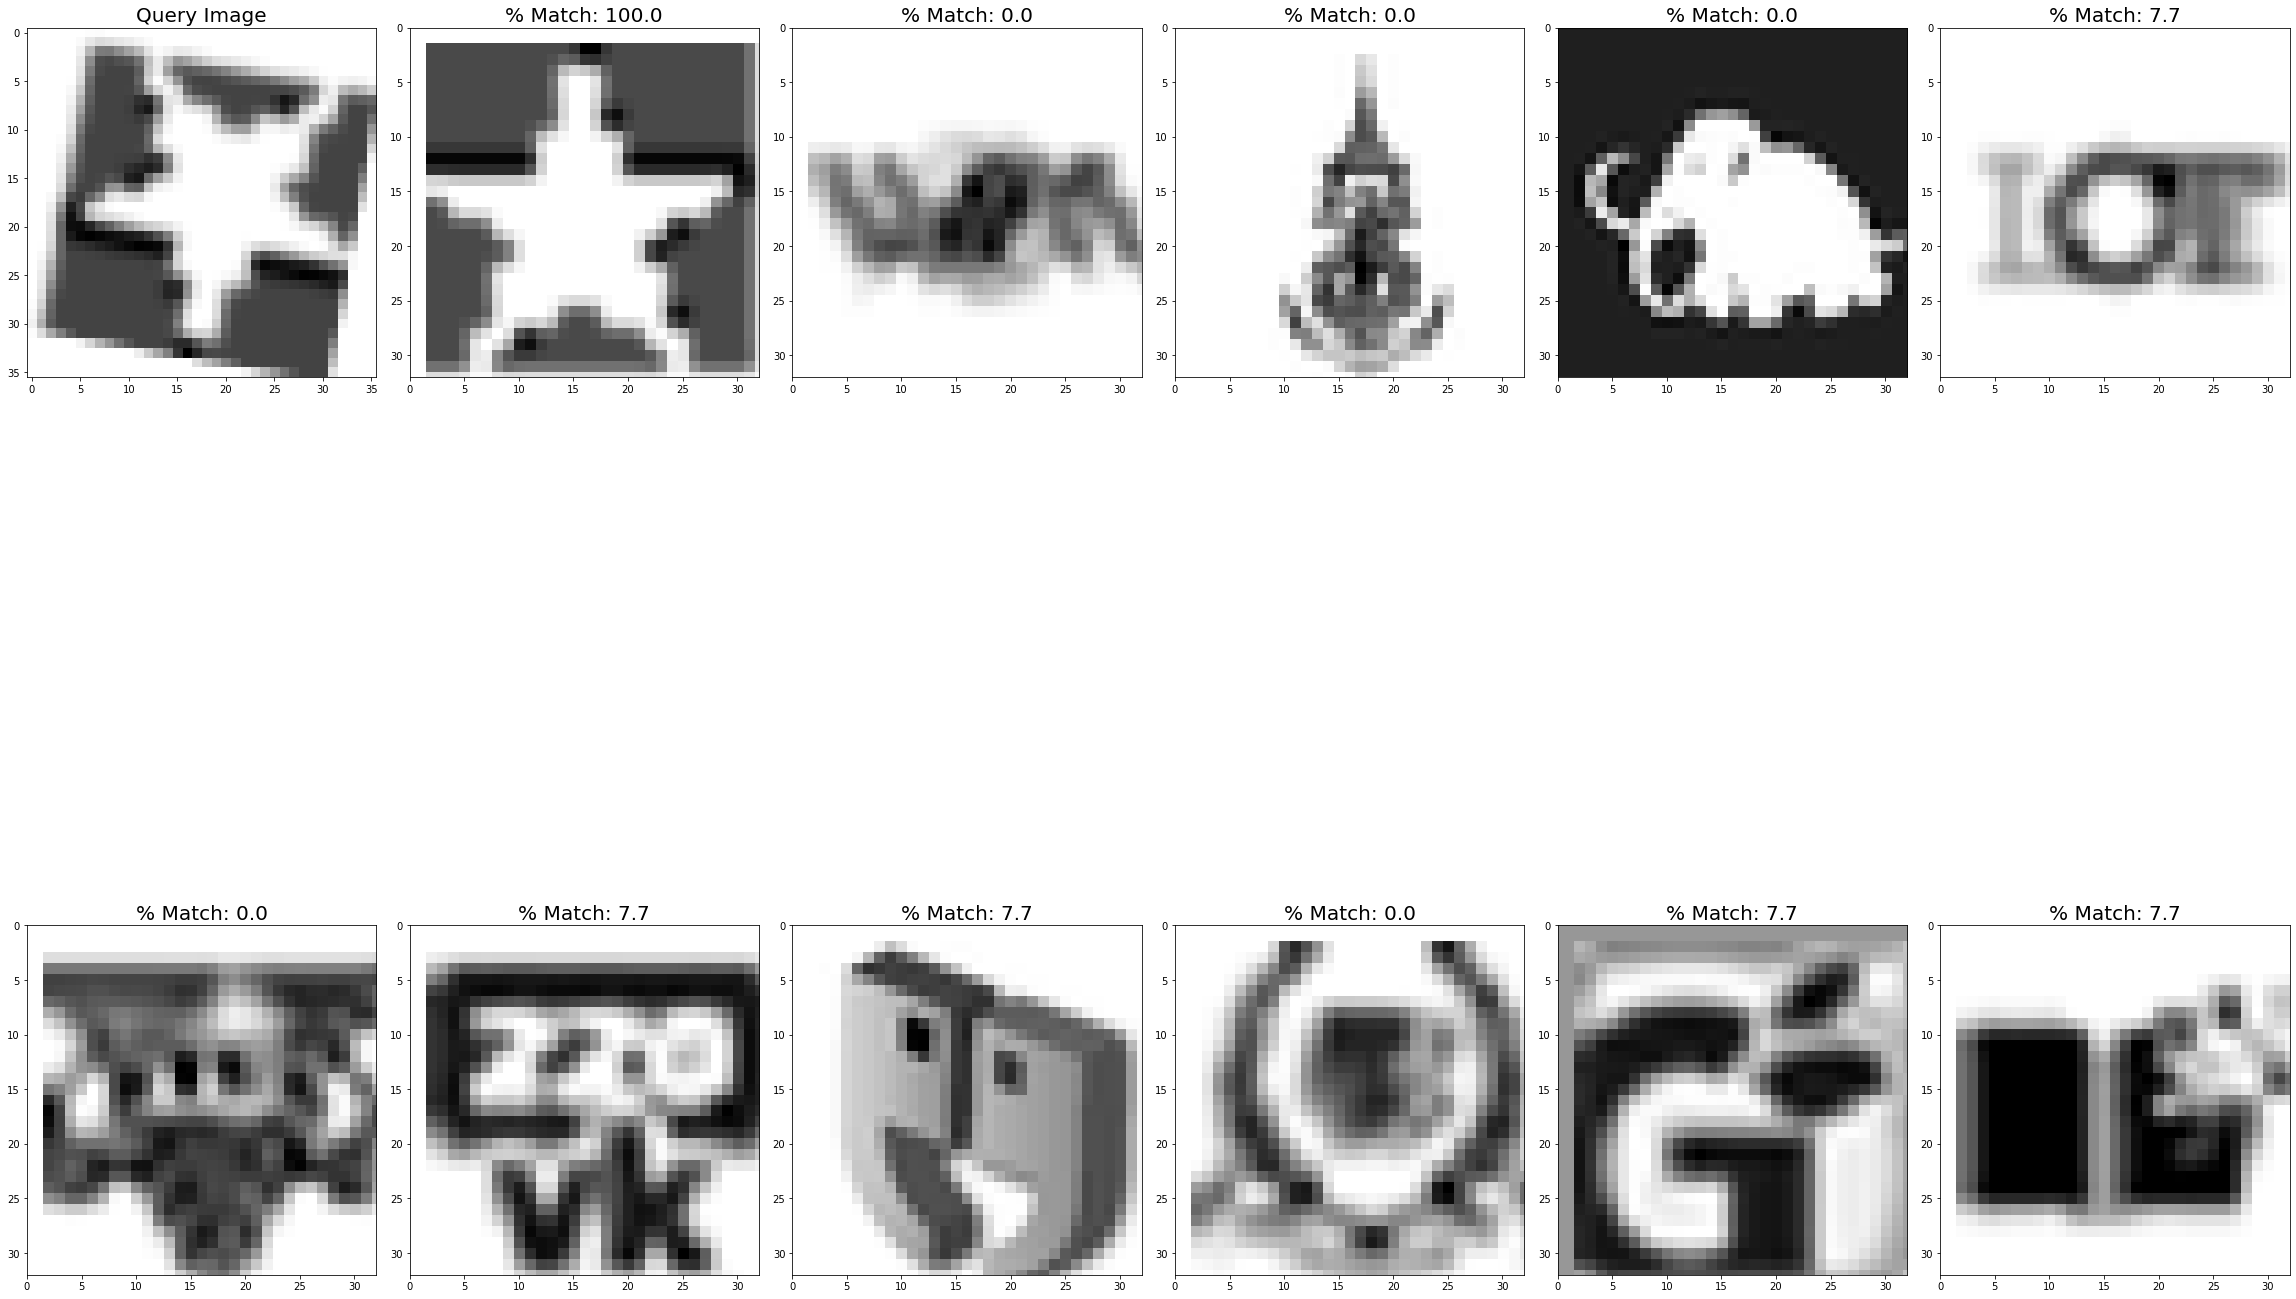

In [21]:
# ## plot query image and top 11 hits, just for checking purposes  
# plot_results(Data, matched_list_v2)

In [6]:
# ## load scores from log files
# success = []
# contour_score = []
# zernike_score = []
# sift_score = []
# orb_score = []
# image = []
# indices = []
# mutation = []
# contour_orig = []
# sift_orig = []

# # loop through image indices of existing queries 
# for fname in tqdm_notebook(os.listdir('.\Logs')):
# 	x1 = fname.find('_')+1
# 	x2 = fname.find('.')
# 	i = int(fname[x1:x2])
# 	indices.append(i)

# 	j = 0
# 	#open log file of query
# 	with open('C:/Users/kchad/Documents/LogoMatch/Logs/' + fname,"r") as myfile:
# 		for line in myfile:
# 			j += 1
# 			if j % 8 == 0:
# 				for k in range(0,result_len):
# 					mutation.append(line[11:])
# 			if j % 8 == 1:
# 				result_len = 0           
# 			#  line has the results 
# 			if j % 8 == 7:
# 				result = eval(line[13:])
# 				result_len = len(result)
# 				first_contour = result[0][1]
# 				first_zernike = result[0][2]
# 				first_sift = result[0][3]
# 				first_orb = result[0][4]
				
# 				# check if the given query result was the original image, 1 for correct, 0 for incorrect
# 				for elem in result:
# 					if elem[0] == i:
# 						success.append(1)
# 					else:
# 						success.append(0)
						
# 					# normalize the contour/zernike scores
# 					if first_contour > 0:                    
# 						contour_score.append( round(elem[1]/first_contour, 3) )
# 					else:
# 						contour_score.append(0)    
                        
# 					if first_zernike > 0:                         
# 						zernike_score.append( round(elem[2]/first_zernike, 3) )
# 					else:
# 						zernike_score.append(0)                        
# 					if first_sift > 0:
# 						sift_score.append( round(elem[3]/first_sift, 3) )
# 					else:
# 						sift_score.append(0)
                        
# 					if first_orb > 0:
# 						orb_score.append( round(elem[4]/first_orb, 3) )
# 					else:
# 						orb_score.append(0)                        

# 					image.append(i)
# 					contour_orig.append(elem[1])     
# 					sift_orig.append(elem[3]) 

# ### save all the scores in a csv file

# input_score = np.array(list(zip(contour_score,zernike_score,sift_score,orb_score,image,success,mutation,contour_orig,sift_orig)))
# input_score = pd.DataFrame(input_score,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])
# print( input_score.head )
# input_score.to_csv (r'input_scores.csv', index = None, header=True)


<bound method NDFrame.head of        contour_score zernike_score sift_score orb_score image success  \
0                1.0           1.0          0       1.0   100       0   
1              0.651           0.0          0     1.149   100       1   
2              0.641         0.991          0     1.095   100       0   
3               0.39         0.992          0     1.095   100       0   
4              0.541         0.651          0      0.77   100       0   
...              ...           ...        ...       ...   ...     ...   
399995         0.081             0        0.0     0.173   199       0   
399996         0.408             0        0.0      0.01   199       0   
399997         0.392             0        0.0       0.0   199       0   
399998         0.379             0        0.0       0.0   199       0   
399999         0.104             0        0.0     0.061   199       0   

                mutation contour_orig sift_orig  
0             ab_scale\n         47.9     

In [8]:
# ###### logsitic regression for weights of 4 methods
# numbers = [i for i in range(100,200)]

# ### randomly create training and test set
# random.shuffle(numbers)
# training = numbers[0:60]
# testing = numbers[60:100]

# ### search for a particular mutation
# mutation_string = 'ab_line_circle'
# print(mutation_string)

# ### set threshold for contour and sift, set accuracy cutoff (top 10 or top 20)
# contour_thresh = 0
# sift_thresh = 0
# rank_cutoff = 20

# ### create training set, filter for mutation name and thresholds 
# input_score_mutation = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(training)) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_mutation = input_score_mutation.values

# ### create test data set, not used for training
# input_score_test = input_score[(input_score["mutation"].str.find(mutation_string) > -1) & (input_score["image"].astype(float).isin(testing) ) & ((input_score["contour_orig"].astype(float) >= contour_thresh) & (input_score["sift_orig"].astype(float) >= sift_thresh))]
# input_score_test = pd.DataFrame(input_score_test,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# ### run logistic regression on training data
# clf = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial').fit(input_score_mutation[:,(0,1,2,3)], input_score_mutation[:,5])
# logistic_weights = clf.coef_[0]/sum(clf.coef_[0])
# print('Logistic Weights')
# print(logistic_weights)

# ### use weights to calculate weighted score and rank on training set
# input_score_mutation = pd.DataFrame(input_score_mutation,columns = ['contour_score','zernike_score','sift_score','orb_score','image','success','mutation','contour_orig','sift_orig'])

# input_score_mutation["contour_score"] = input_score_mutation["contour_score"].astype(float)
# input_score_mutation["zernike_score"] = input_score_mutation["zernike_score"].astype(float)
# input_score_mutation["sift_score"] = input_score_mutation["sift_score"].astype(float)
# input_score_mutation["orb_score"] = input_score_mutation["orb_score"].astype(float)

# input_score_mutation["avg_score"] = .25*input_score_mutation["contour_score"] + .25*input_score_mutation["zernike_score"] + .25*input_score_mutation["sift_score"] + .25*input_score_mutation["orb_score"]
# input_score_mutation["weight_score"] = logistic_weights[0]*input_score_mutation["contour_score"] + logistic_weights[1]*input_score_mutation["zernike_score"] + logistic_weights[2]*input_score_mutation["sift_score"] + logistic_weights[3]*input_score_mutation["orb_score"]
# input_score_mutation['Avg_Rank'] = input_score_mutation.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_mutation['Weight_Rank'] = input_score_mutation.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### use weights to calculate weighted score and rank on test set
# input_score_test["contour_score"] = input_score_test["contour_score"].astype(float)
# input_score_test["zernike_score"] = input_score_test["zernike_score"].astype(float)
# input_score_test["sift_score"] = input_score_test["sift_score"].astype(float)
# input_score_test["orb_score"] = input_score_test["orb_score"].astype(float)

# input_score_test["avg_score"] = .25*input_score_test["contour_score"] + .25*input_score_test["zernike_score"] + .25*input_score_test["sift_score"] + .25*input_score_test["orb_score"]
# input_score_test["weight_score"] = logistic_weights[0]*input_score_test["contour_score"] + logistic_weights[1]*input_score_test["zernike_score"] + logistic_weights[2]*input_score_test["sift_score"] + logistic_weights[3]*input_score_test["orb_score"]
# input_score_test['Avg_Rank'] = input_score_test.groupby(['image','mutation'])['avg_score'].rank(ascending=False)	
# input_score_test['Weight_Rank'] = input_score_test.groupby(['image','mutation'])['weight_score'].rank(ascending=False)	

# ### check the rank of the original image, see if image was within the top 10 or top 20 search results
# successes = input_score_mutation[input_score_mutation["success"].astype(float) == 1]

# avg_rank = sum(successes['Avg_Rank'])/successes.shape[0]
# weight_rank = sum(successes['Weight_Rank'])/successes.shape[0]
# top10_avg_rank = len( successes[(successes['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank = len( successes[(successes['Weight_Rank'] <= rank_cutoff)] )

# print('Training Accuracy')
# print((top10_avg_rank,top10_weight_rank))

# successes_t = input_score_test[input_score_test["success"].astype(float) == 1]

# avg_rank_t = sum(successes_t['Avg_Rank'])/successes_t.shape[0]
# weight_rank_t = sum(successes_t['Weight_Rank'])/successes_t.shape[0]
# top10_avg_rank_t = len( successes_t[(successes_t['Avg_Rank'] <= rank_cutoff)] )
# top10_weight_rank_t = len( successes_t[(successes_t['Weight_Rank'] <= rank_cutoff)] )

# print('Testing Accuracy')
# print((top10_avg_rank_t,top10_weight_rank_t))

# #input_score.to_csv(path_or_buf='./score_result_2.csv', sep=',',index = False)

ab_line_circle
Logistic Weights
[ 0.39758687 -0.00080109  0.24339924  0.35981498]
Training Accuracy
(23.683333333333334, 23.1, 52, 54)
Testing Accuracy
(10.4625, 13.05, 35, 35)


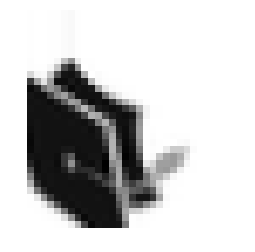

In [41]:
# ### display an image
# image_index = 50
# Data = gray(images[image_index])
# Data, mutation = ab_random(Data, n = 9)

# imgplot = plt.imshow(Data, cmap=plt.cm.gray)
# plt.axis('off')
# plt.show()